<a href="https://colab.research.google.com/github/Brotherswords/DeepLearning_Project/blob/main/CSCI4931_U_Net_Final_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Brian H., Jake M., Lavan V., Matthew W.
# CSCI 4931 - Deep Learning Final Project
# Wave-U-Net ح

In [ ]:
# Environment
# !pip install librosa tensorflow
# !pip install tensorflow

In [ ]:
# !pip install tensorflow

In [ ]:
# Wave-U-Net Model
import tensorflow as tf
import numpy as np
# https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv1D
# https://www.tensorflow.org/api_docs/python/tf/keras/layers/
# https://www.tensorflow.org/api_docs/python/tf/keras/layers/UpSampling1D
# https://www.tensorflow.org/api_docs/python/tf/keras/layers/Concatenate
# https://www.tensorflow.org/api_docs/python/tf/keras/layers/Normalization
# https://www.tensorflow.org/api_docs/python/tf/keras/layers/BatchNormalization
from tensorflow.keras.layers import Conv1D, MaxPooling1D, UpSampling1D, Concatenate, Normalization, BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D, Concatenate, Normalization, BatchNormalization


In [ ]:
print(tf.__version__)

2.14.0


In [ ]:
# mount Google Drive to the Colab VM
from google.colab import drive
import os
import zipfile

drive.mount('/content/drive')

# Mount Google Drive
# drive.mount("/content/drive", force_remount=True)

# Replace 'YourFolderName' with the name of your folder
# folder_path = '/content/drive/My Drive/datasets/DSD100subset.zip'
folder_path = '/content/drive/My Drive/datasets/DSD100.zip'


# # List all files in the directory -> use this to figure out the exact
# for file in os.listdir(folder_path):
#     print(file)
print("Mounted Successfully")


Mounted at /content/drive
Mounted Successfully


# Data Preparation 💽

In [ ]:
import zipfile

# Path to the zip file
# Its not Gojover yet
# Path to the DSD100 zip file
zip_file_path = '/content/drive/My Drive/datasets/DSD100.zip'

# TEST SUBSET !!!!
# zip_file_path = '/content/drive/My Drive/datasets/DSD100subset.zip'


# Function to process the zip file
mixtures_dict = {}
sources_dict = {}

# Function to process the zip file
def process_dsd100_zip(zip_path):
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        for file in zip_ref.namelist():
            if 'Mixtures/Test/' in file and file.endswith('mixture.wav'):
                key = file.split('/')[-2]  # Extract song key
                # print(key)
                mixtures_dict[key] = file
            elif 'Sources/Test/' in file and file.endswith(('.wav')):
                key = file.split('/')[-2]  # Extract song key
                if key not in sources_dict:
                    sources_dict[key] = []
                sources_dict[key].append(file)


# Process the DSD100 zip file
process_dsd100_zip(zip_file_path)


# Create Mixtures and Sources lists
Mixtures = []
Sources = []


for key, mixture_path in mixtures_dict.items():
    Mixtures.append(mixture_path)
    Sources.append(sources_dict.get(key, []))  # Get the sources, or an empty list if not found


# Displaying the first few paths for verification
print("First mixture:", Mixtures[0])
print("First source tuple:", Sources[0])


# # Open the zip file and list its contents
# with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
#     for file in zip_ref.namelist():
#         print(file)

First mixture: DSD100/Mixtures/Test/050 - Zeno - Signs/mixture.wav
First source tuple: ['DSD100/Sources/Test/050 - Zeno - Signs/vocals.wav', 'DSD100/Sources/Test/050 - Zeno - Signs/other.wav', 'DSD100/Sources/Test/050 - Zeno - Signs/drums.wav', 'DSD100/Sources/Test/050 - Zeno - Signs/bass.wav']


In [ ]:
# Loss Function
# https://www.tensorflow.org/api_docs/python/tf/keras/losses/MeanSquaredError
loss_func = tf.keras.losses.MeanSquaredError()
# Metrics
# https://www.tensorflow.org/api_docs/python/tf/keras/losses/MeanAbsoluteError
metrics = [tf.keras.metrics.MeanAbsoluteError()]
# Optimizer Func
# https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/Adam
optimizer = tf.optimizers.Adam(learning_rate=0.001)

In [ ]:
#Extracting all the mixture files into a temp location not files :3
import shutil
from IPython.display import Audio
import os
import zipfile

mixtures_train = []

def extract_and_play_attempt(file_path_in_zip, some_string_as_input):
    # Create the directory if it does not exist
    target_directory = '/tmp/train-mix/'
    if not os.path.exists(target_directory):
        os.makedirs(target_directory)

    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
        if file_path_in_zip in zip_ref.namelist():
            # Extract the original file name and create a new file name
            original_filename = os.path.basename(file_path_in_zip)
            new_filename = f"{some_string_as_input} - {original_filename}"
            extracted_file_path = os.path.join(target_directory, new_filename)
            mixtures_train.append(extracted_file_path)

            # Read the file data from the zip file
            with zip_ref.open(file_path_in_zip) as source_file:
                # Write the file data to the new file in the target directory
                with open(extracted_file_path, 'wb') as target_file:
                    target_file.write(source_file.read())

            print(f"Extracted to: {extracted_file_path}")

            # Check if the file exists at the extracted path
            if os.path.exists(extracted_file_path):
                print(extracted_file_path)
                return Audio(filename=extracted_file_path)
            else:
                print("Extracted file not found.")
                return None
        else:
            print("File not found in the zip archive.")
            return None

def get_second_to_last_value(input_string, delimiter):
    """
    Splits the input string using the given delimiter and returns the second-to-last value
    from the resulting split array. If the array has less than two elements, returns None.

    :param input_string: The string to be split
    :param delimiter: The delimiter to use for splitting the string
    :return: The second-to-last value from the split array or None
    """
    parts = input_string.split(delimiter)
    if len(parts) >= 2:
        return parts[-2]  # Get the second-to-last element
    else:
        return None

storage_location = []
for idx in range(len(Mixtures)):
  mix = Mixtures[idx]
  append_name = get_second_to_last_value(mix, "/")
  print("Amogus", mix)
  filename = os.path.basename(mix)
  print(filename)
  local_path = '/tmp/train-mix/' + str(idx) + filename
  extract_and_play_attempt(mix, append_name)

print("Extracted Mixtures to test Location")

Amogus DSD100/Mixtures/Test/050 - Zeno - Signs/mixture.wav
mixture.wav
Extracted to: /tmp/train-mix/050 - Zeno - Signs - mixture.wav
/tmp/train-mix/050 - Zeno - Signs - mixture.wav
Amogus DSD100/Mixtures/Test/048 - We Fell From The Sky - Not You/mixture.wav
mixture.wav
Extracted to: /tmp/train-mix/048 - We Fell From The Sky - Not You - mixture.wav
/tmp/train-mix/048 - We Fell From The Sky - Not You - mixture.wav
Amogus DSD100/Mixtures/Test/047 - Voelund - Comfort Lives In Belief/mixture.wav
mixture.wav
Extracted to: /tmp/train-mix/047 - Voelund - Comfort Lives In Belief - mixture.wav
/tmp/train-mix/047 - Voelund - Comfort Lives In Belief - mixture.wav
Amogus DSD100/Mixtures/Test/046 - Triviul - Dorothy/mixture.wav
mixture.wav
Extracted to: /tmp/train-mix/046 - Triviul - Dorothy - mixture.wav
/tmp/train-mix/046 - Triviul - Dorothy - mixture.wav
Amogus DSD100/Mixtures/Test/045 - Traffic Experiment - Sirens/mixture.wav
mixture.wav
Extracted to: /tmp/train-mix/045 - Traffic Experiment - Si

In [ ]:
def get_key_sep(file_path):
    """
    Splits the file path by "/" and returns the first three characters of the last element.

    :param file_path: The file path string.
    :return: The first three characters of the file name.
    """
    # Split the file path by "/"
    parts = file_path.split('/')

    # Get the last element of the parts list
    file_name = parts[-2]

    # Return the first three characters of the file name
    return file_name[:3]

In [ ]:
# Separating the different channels into their own directories

separation_train_vocals, separation_train_drums, separation_train_bass, separation_train_other = {}, {}, {}, {}
def extract_files_separation(file_paths_in_zip, subfolder_name):
    # Create the base directory if it does not exist
    base_directory = '/tmp/train-sep/'
    if not os.path.exists(base_directory):
        os.makedirs(base_directory)

    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
        for file_path in file_paths_in_zip:
            if file_path in zip_ref.namelist():
                channel_name = file_path.split('/')[-1].split('.')[0]
                base_directory = f'/tmp/train-sep/{channel_name}'
                if not os.path.exists(base_directory):
                    os.makedirs(base_directory)
                # Create the subfolder directory
                target_directory = os.path.join(base_directory, subfolder_name)
                if not os.path.exists(target_directory):
                    os.makedirs(target_directory)
                # Get the file name and create the path in the subfolder
                filename = os.path.basename(file_path)
                # filename = os.path.join(filename, channel_name)
                extracted_file_path = os.path.join(target_directory, filename)
                # separation_train.append(extracted_file_path)
                # separation_train[channel_name].append(extracted_file_path)
                if channel_name == 'vocals':
                    separation_train_vocals[get_key_sep(extracted_file_path)] = extracted_file_path
                if channel_name == 'drums':
                    separation_train_drums[get_key_sep(extracted_file_path)] = extracted_file_path
                if channel_name == 'bass':
                    separation_train_bass[get_key_sep(extracted_file_path)] = extracted_file_path
                if channel_name == 'other':
                    separation_train_other[get_key_sep(extracted_file_path)] = extracted_file_path
                # Read the file data from the zip file
                with zip_ref.open(file_path) as source_file:
                    # Write the file data to the new file in the target directory
                    with open(extracted_file_path, 'wb') as target_file:
                        target_file.write(source_file.read())

                print(f"Extracted to: {extracted_file_path}")
            else:
                print(f"File not found in the zip archive: {file_path}")

def get_second_to_last_value(input_string, delimiter):
    """
    Splits the input string using the given delimiter and returns the second-to-last value
    from the resulting split array. If the array has less than two elements, returns None.

    :param input_string: The string to be split
    :param delimiter: The delimiter to use for splitting the string
    :return: The second-to-last value from the split array or None
    """
    parts = input_string.split(delimiter)
    if len(parts) >= 2:
        return parts[-2]  # Get the second-to-last element
    else:
        return None

# Example usage
storage_location = []
for idx in range(len(Sources)):
  sep = Sources[idx]
  append_name = get_second_to_last_value(sep[0], "/")

  print("Amogus", sep)
  # print("Amogus", channel_name)
  # local_path = '/tmp/train-mix/' + str(idx) + filename
  extract_files_separation(sep, append_name)
# print(len(separation_train))

Amogus ['DSD100/Sources/Test/050 - Zeno - Signs/vocals.wav', 'DSD100/Sources/Test/050 - Zeno - Signs/other.wav', 'DSD100/Sources/Test/050 - Zeno - Signs/drums.wav', 'DSD100/Sources/Test/050 - Zeno - Signs/bass.wav']
Extracted to: /tmp/train-sep/vocals/050 - Zeno - Signs/vocals.wav
Extracted to: /tmp/train-sep/other/050 - Zeno - Signs/other.wav
Extracted to: /tmp/train-sep/drums/050 - Zeno - Signs/drums.wav
Extracted to: /tmp/train-sep/bass/050 - Zeno - Signs/bass.wav
Amogus ['DSD100/Sources/Test/048 - We Fell From The Sky - Not You/vocals.wav', 'DSD100/Sources/Test/048 - We Fell From The Sky - Not You/other.wav', 'DSD100/Sources/Test/048 - We Fell From The Sky - Not You/drums.wav', 'DSD100/Sources/Test/048 - We Fell From The Sky - Not You/bass.wav']
Extracted to: /tmp/train-sep/vocals/048 - We Fell From The Sky - Not You/vocals.wav
Extracted to: /tmp/train-sep/other/048 - We Fell From The Sky - Not You/other.wav
Extracted to: /tmp/train-sep/drums/048 - We Fell From The Sky - Not You/dr

## Reorganizing the Separation Data 🔄
First converting the filepaths into a list so we can process it later.

In [ ]:
separation_train_vocals_paths = list(separation_train_vocals.values())
separation_train_drums_paths = list(separation_train_drums.values())
separation_train_bass_paths = list(separation_train_bass.values())
separation_train_other_paths = list(separation_train_other.values())

In [ ]:
def get_key(file_path):
    """
    Splits the file path by "/" and returns the first three characters of the last element.

    :param file_path: The file path string.
    :return: The first three characters of the file name.
    """
    # Split the file path by "/"
    parts = file_path.split('/')

    # Get the last element of the parts list
    file_name = parts[-1]

    # Return the first three characters of the file name
    return file_name[:3]

## Prepping the Separation Data by Padding the Spectrograms 📊
We can do this by first figuring out what lengths encapsulate most spectrograms. This has been set to 50 largely due to computational constraints.

In [ ]:
import librosa
import numpy as np

segment_length = 10  # 10 seconds
sr = 22050  # Sample rate
n_fft = 2048
hop_length = 512

lengths = []
for file_path in mixtures_train:  # Replace with your list of file paths
    audio, sr = librosa.load(file_path, sr=None)
    spectrogram = np.abs(librosa.stft(audio, n_fft=n_fft, hop_length=hop_length))
    lengths.append(spectrogram.shape[1])

# Choose your percentile (e.g., 50th percentile, Basically 50% of all the tracks are this length or
# under) - Chosen because we're close to maxing out on ram during data-preprocessing, can't afford
# any more computational costs without runtime crashing.
percentile = 50

# Calculate the desired_length
desired_length = int(np.percentile(lengths, percentile))

print(f"Desired Length (at {percentile}th percentile): {desired_length}")


Desired Length (at 50th percentile): 20680


## Grouping the Data by Keys 🔐

We group the data by looking at what song number it has so we can find which mixtures correspond to which seperations.


In [ ]:
import librosa
import numpy as np
import os
from collections import defaultdict
from tensorflow.keras.utils import Sequence

spect_mixtures_map = {}

segment_length = 10  # 10 seconds
sr = 22050  # Sample rate
n_fft = 2048
hop_length = 512


def audio_length_to_time_steps(audio_length, sr, n_fft, hop_length):
    """
    Convert audio length in seconds to number of time steps in the spectrogram.

    :param audio_length: Length of the audio in seconds.
    :param sr: Sample rate of the audio.
    :param n_fft: Number of FFT components.
    :param hop_length: Number of samples between successive frames.
    :return: Number of time steps in the spectrogram.
    """
    # Calculate the total number of samples
    num_samples = int(audio_length * sr)

    # Calculate the number of time steps in the spectrogram
    num_time_steps = (num_samples - n_fft) // hop_length + 1

    return num_time_steps


desired_length = audio_length_to_time_steps(segment_length, sr, n_fft, hop_length)

class DataGenerator(Sequence):
    """
    DataGenerator is a custom class that inherits from Sequence.
    It generates data in batches, which is efficient for memory usage.
    The generator can be directly used with Keras's model.fit method for training.
    """
    def __init__(self, file_paths, batch_size, n_fft, hop_length, desired_length, sr=22050):
        self.file_paths = file_paths
        self.batch_size = batch_size
        self.n_fft = n_fft
        self.hop_length = hop_length
        self.desired_length = desired_length
        self.sr = sr

    def __len__(self):
        return int(np.ceil(len(self.file_paths) / self.batch_size))

    def __getitem__(self, idx):
        batch_paths = self.file_paths[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_spectrograms = [audio_to_spectrogram_mixture(path, self.n_fft, self.hop_length, self.desired_length) for path in batch_paths]
        batch_spectrograms = np.array(batch_spectrograms)
        return batch_spectrograms

# For Mixtures
def audio_to_spectrogram_mixture(file_path, n_fft=2048, hop_length=512, desired_length=20680):
    """
    Convert an audio file to a spectrogram with an added channel dimension.

    :param file_path: Path to the audio file.
    :param n_fft: Number of FFT components.
    :param hop_length: Number of samples between successive frames.
    :param desired_length: The desired number of time steps in the spectrogram.
    :return: Spectrogram of the audio file with shape (time, frequency, 1).
    """
    # Load the audio file
    audio, sr = librosa.load(file_path, sr=None)

    # Compute the Short-Time Fourier Transform (STFT)
    spectrogram = np.abs(librosa.stft(audio, n_fft=n_fft, hop_length=hop_length))

    # Convert to logarithmic scale
    spectrogram = librosa.amplitude_to_db(spectrogram)

    # Trimming or Padding the Spectrogram to a fixed size
    if desired_length is not None:
        if spectrogram.shape[1] > desired_length:
            # Trim the spectrogram
            spectrogram = spectrogram[:, :desired_length]
        else:
            # Pad the spectrogram
            padding = desired_length - spectrogram.shape[1]
            spectrogram = np.pad(spectrogram, ((0, 0), (0, padding)), mode='constant')

    # Add a channel dimension
    spectrogram = np.expand_dims(spectrogram, axis=-1)

    spect_mixtures_map[get_key(file_path)] = spectrogram

    return spectrogram


# Different function because of how the filepath of the separations is handled - besides this they are functionally equivalent

def audio_to_spectrogram_separate(file_path, sep_dict, n_fft=2048, hop_length=512, desired_length=20680):
    """
    Convert an audio file to a spectrogram with an added channel dimension.

    :param file_path: Path to the audio file.
    :param n_fft: Number of FFT components.
    :param hop_length: Number of samples between successive frames.
    :param desired_length: The desired number of time steps in the spectrogram.
    :return: Spectrogram of the audio file with shape (time, frequency, 1).
    """
    # Load the audio file
    audio, sr = librosa.load(file_path, sr=None)

    # Compute the Short-Time Fourier Transform (STFT)
    spectrogram = np.abs(librosa.stft(audio, n_fft=n_fft, hop_length=hop_length))

    # Convert to logarithmic scale
    spectrogram = librosa.amplitude_to_db(spectrogram)

    # Trimming or Padding the Spectrogram to a fixed size
    if desired_length is not None:
        if spectrogram.shape[1] > desired_length:
            # Trim the spectrogram
            spectrogram = spectrogram[:, :desired_length]
        else:
            # Pad the spectrogram
            padding = desired_length - spectrogram.shape[1]
            spectrogram = np.pad(spectrogram, ((0, 0), (0, padding)), mode='constant')

    # Add a channel dimension
    spectrogram = np.expand_dims(spectrogram, axis=-1)

    sep_dict[get_key_sep(file_path)] = spectrogram

    return spectrogram

#Keys for the spectrograms of each kind.
spect_seperate_vocals = {}
spect_seperate_drums = {}
spect_seperate_bass = {}
spect_seperate_other = {}

# Now, 'spectrograms' contains the spectrogram of each audio file


In [ ]:
print(mixtures_train)

['/tmp/train-mix/050 - Zeno - Signs - mixture.wav', '/tmp/train-mix/048 - We Fell From The Sky - Not You - mixture.wav', '/tmp/train-mix/047 - Voelund - Comfort Lives In Belief - mixture.wav', '/tmp/train-mix/046 - Triviul - Dorothy - mixture.wav', '/tmp/train-mix/045 - Traffic Experiment - Sirens - mixture.wav', '/tmp/train-mix/044 - Tom McKenzie - Directions - mixture.wav', '/tmp/train-mix/043 - Timboz - Pony - mixture.wav', "/tmp/train-mix/042 - The Wrong'Uns - Rothko - mixture.wav", '/tmp/train-mix/041 - The Mountaineering Club - Mallory - mixture.wav', '/tmp/train-mix/040 - The Long Wait - Back Home To Blue - mixture.wav', '/tmp/train-mix/039 - Swinging Steaks - Lost My Way - mixture.wav', "/tmp/train-mix/038 - Spike Mullings - Mike's Sulking - mixture.wav", '/tmp/train-mix/037 - Speak Softly - Broken Man - mixture.wav', '/tmp/train-mix/036 - Skelpolu - Resurrection - mixture.wav', '/tmp/train-mix/035 - Signe Jakobsen - What Have You Done To Me - mixture.wav', '/tmp/train-mix/034 

In [ ]:
print(separation_train_vocals_paths)
print(separation_train_drums_paths)
print(separation_train_bass_paths)
print(separation_train_other_paths)

['/tmp/train-sep/vocals/050 - Zeno - Signs/vocals.wav', '/tmp/train-sep/vocals/048 - We Fell From The Sky - Not You/vocals.wav', '/tmp/train-sep/vocals/047 - Voelund - Comfort Lives In Belief/vocals.wav', '/tmp/train-sep/vocals/046 - Triviul - Dorothy/vocals.wav', '/tmp/train-sep/vocals/045 - Traffic Experiment - Sirens/vocals.wav', '/tmp/train-sep/vocals/044 - Tom McKenzie - Directions/vocals.wav', '/tmp/train-sep/vocals/043 - Timboz - Pony/vocals.wav', "/tmp/train-sep/vocals/042 - The Wrong'Uns - Rothko/vocals.wav", '/tmp/train-sep/vocals/041 - The Mountaineering Club - Mallory/vocals.wav', '/tmp/train-sep/vocals/040 - The Long Wait - Back Home To Blue/vocals.wav', '/tmp/train-sep/vocals/039 - Swinging Steaks - Lost My Way/vocals.wav', "/tmp/train-sep/vocals/038 - Spike Mullings - Mike's Sulking/vocals.wav", '/tmp/train-sep/vocals/037 - Speak Softly - Broken Man/vocals.wav', '/tmp/train-sep/vocals/036 - Skelpolu - Resurrection/vocals.wav', '/tmp/train-sep/vocals/035 - Signe Jakobsen 

## Now Let's Fill Our Dictionary's with Data 📁

In [ ]:
for file in mixtures_train:
  audio_to_spectrogram_mixture(file)


In [ ]:
for file in separation_train_vocals_paths:
  audio_to_spectrogram_separate(file, spect_seperate_vocals)

for file in separation_train_drums_paths:
  audio_to_spectrogram_separate(file, spect_seperate_drums)

for file in separation_train_bass_paths:
  audio_to_spectrogram_separate(file, spect_seperate_bass)

for file in separation_train_other_paths:
  audio_to_spectrogram_separate(file, spect_seperate_other)

## Let's Load Our Data from Google Drive w/Pickle 🥒
We use Pickle to load our data as .pkl files saving us some time by not having to repeat the time consuming preprocessing steps from before!

It's saved initially in a later step.

In [ ]:
import pickle

# Define the directory path
directory_path = "/content/drive/My Drive/datasets/"

# Load vocals data
with open(directory_path + 'vocals_data.pkl', 'rb') as file:
    spect_separate_tuples_vocals = pickle.load(file)

# Load drums data
with open(directory_path + 'drums_data.pkl', 'rb') as file:
    spect_separate_tuples_drums = pickle.load(file)

# Load bass data
with open(directory_path + 'bass_data.pkl', 'rb') as file:
    spect_separate_tuples_bass = pickle.load(file)

# Load other data
with open(directory_path + 'other_data.pkl', 'rb') as file:
    spect_separate_tuples_other = pickle.load(file)

# Load mixture data
with open(directory_path + 'mixture_data.pkl', 'rb') as file:
    spect_mixtures_array = pickle.load(file)

# Now, vocals_data, drums_data, bass_data, other_data, and mixture_data are arrays loaded from the pickle files


## Now we actually create our Training Set by Key Number in Ascending Order 🔢📈

In [ ]:
lengths_test =[]
for i in range(1, 51):
    key = f"{i:03}"
    if key in spect_mixtures_map:
        print(f"Key {key} found.")
        lengths_test.append(len(spect_mixtures_map[key]))
    else:
        print(f"Key {key} not found in spect_mixtures_map")


# Create an array with values from spect_mixtures_map in order
spect_mixtures_array = [spect_mixtures_map[f"{i:03}"] for i in range(1, 51)]

# Create an array of tuples from spect_seperate_map
spect_separate_tuples_vocals = [spect_seperate_vocals[f"{i:03}"] for i in range(1, 51)]
spect_separate_tuples_drums = [spect_seperate_drums[f"{i:03}"] for i in range(1, 51)]
spect_separate_tuples_bass = [spect_seperate_bass[f"{i:03}"] for i in range(1, 51)]
spect_separate_tuples_other = [spect_seperate_other[f"{i:03}"] for i in range(1, 51)]

# Verify the first elements and the length of the arrays
if spect_mixtures_array and spect_separate_tuples_vocals and spect_separate_tuples_bass and spect_separate_tuples_drums and spect_separate_tuples_other:
    #Ensure the data is all the same size
    assert(len(spect_mixtures_array) == len(spect_separate_tuples_vocals) == len(spect_separate_tuples_drums) == len(spect_separate_tuples_bass) == len(spect_separate_tuples_other))

average = sum(lengths_test) / len(lengths_test)
print(max(lengths_test))
print(min(lengths_test))
print(average)


Key 001 found.
Key 002 found.
Key 003 found.
Key 004 found.
Key 005 found.
Key 006 found.
Key 007 found.
Key 008 found.
Key 009 found.
Key 010 found.
Key 011 found.
Key 012 found.
Key 013 found.
Key 014 found.
Key 015 found.
Key 016 found.
Key 017 found.
Key 018 found.
Key 019 found.
Key 020 found.
Key 021 found.
Key 022 found.
Key 023 found.
Key 024 found.
Key 025 found.
Key 026 found.
Key 027 found.
Key 028 found.
Key 029 found.
Key 030 found.
Key 031 found.
Key 032 found.
Key 033 found.
Key 034 found.
Key 035 found.
Key 036 found.
Key 037 found.
Key 038 found.
Key 039 found.
Key 040 found.
Key 041 found.
Key 042 found.
Key 043 found.
Key 044 found.
Key 045 found.
Key 046 found.
Key 047 found.
Key 048 found.
Key 049 found.
Key 050 found.
1025
1025
1025.0


## Let's visualize our Data 👀
By visualizing our data we can ensure its validity! Furthermore, we converted our transformed training data back into audio (with the help of inverse fourier transform) to make sure that it was still audible sound.

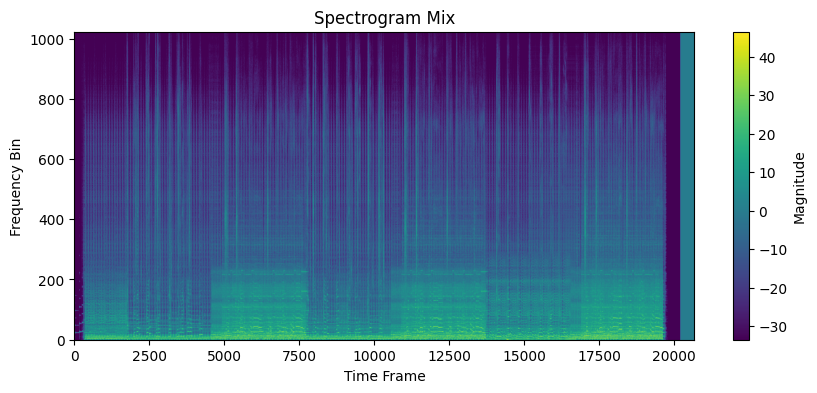

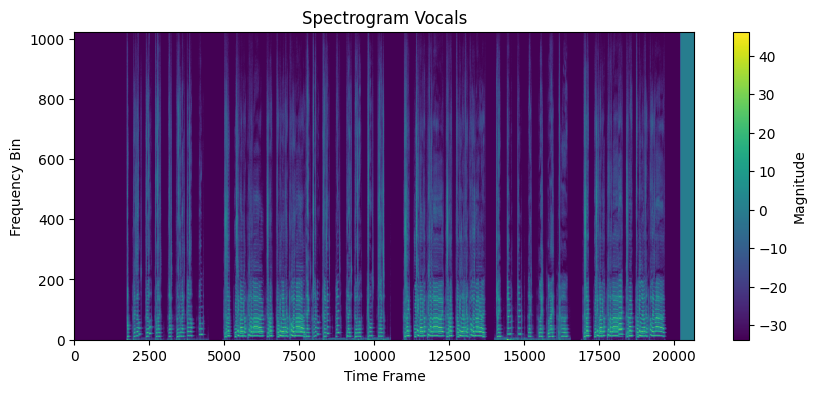

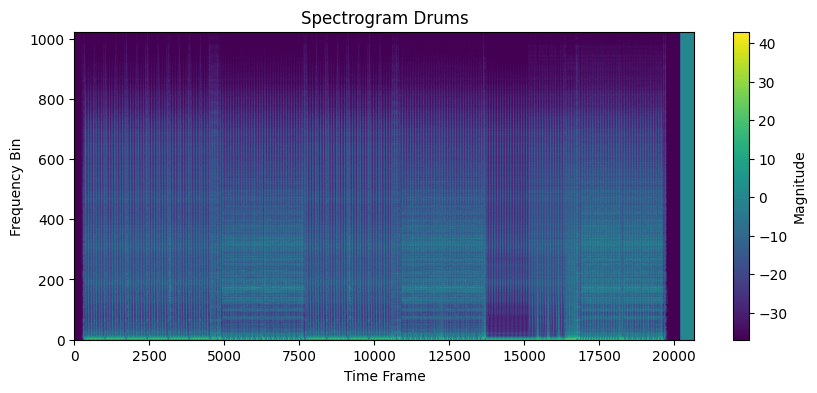

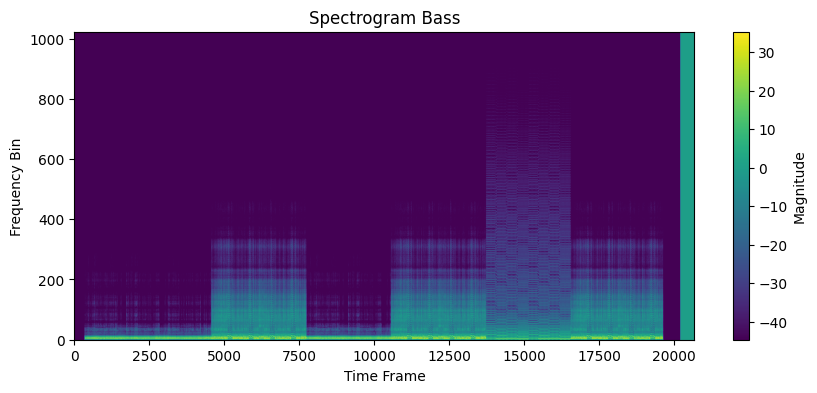

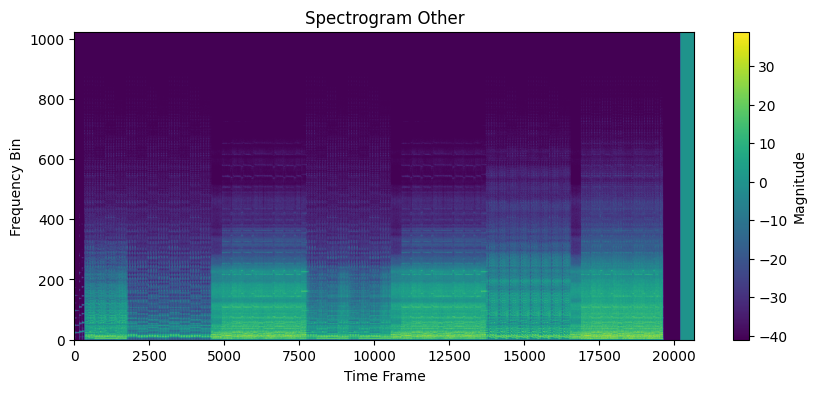

In [ ]:
import matplotlib.pyplot as plt

# Assuming spectrograms_mixtures is a list of spectrogram numpy arrays
spectrogram = spect_mixtures_map["050"]

plt.figure(figsize=(10, 4))
plt.imshow(spectrogram, aspect='auto', origin='lower')
plt.title('Spectrogram Mix')
plt.ylabel('Frequency Bin')
plt.xlabel('Time Frame')
plt.colorbar(label='Magnitude')
plt.show()

spectrogram = spect_seperate_vocals["050"]

plt.figure(figsize=(10, 4))
plt.imshow(spectrogram, aspect='auto', origin='lower')
plt.title('Spectrogram Vocals')
plt.ylabel('Frequency Bin')
plt.xlabel('Time Frame')
plt.colorbar(label='Magnitude')
plt.show()

spectrogram = spect_seperate_drums["050"]

plt.figure(figsize=(10, 4))
plt.imshow(spectrogram, aspect='auto', origin='lower')
plt.title('Spectrogram Drums')
plt.ylabel('Frequency Bin')
plt.xlabel('Time Frame')
plt.colorbar(label='Magnitude')
plt.show()

spectrogram = spect_seperate_bass["050"]

plt.figure(figsize=(10, 4))
plt.imshow(spectrogram, aspect='auto', origin='lower')
plt.title('Spectrogram Bass')
plt.ylabel('Frequency Bin')
plt.xlabel('Time Frame')
plt.colorbar(label='Magnitude')
plt.show()

spectrogram = spect_seperate_other["050"]

plt.figure(figsize=(10, 4))
plt.imshow(spectrogram, aspect='auto', origin='lower')
plt.title('Spectrogram Other')
plt.ylabel('Frequency Bin')
plt.xlabel('Time Frame')
plt.colorbar(label='Magnitude')
plt.show()

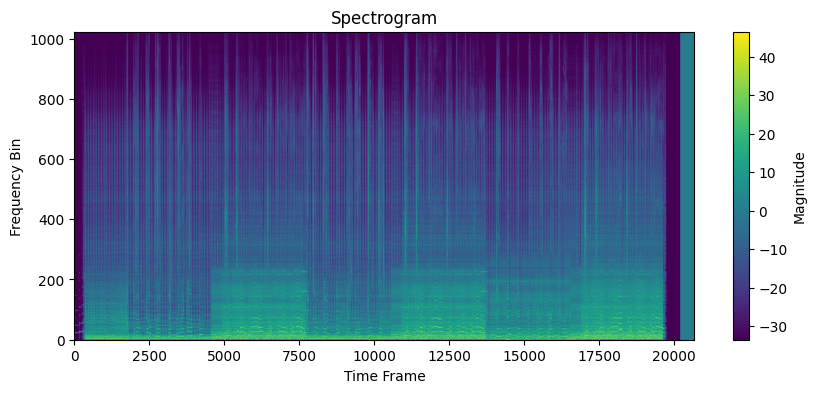

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
# Assuming spectrograms_mixtures is a list of spectrogram numpy arrays
spectrogram = np.load('/content/drive/My Drive/datasets/train_mix_9.npy')

plt.figure(figsize=(10, 4))
plt.imshow(spectrogram, aspect='auto', origin='lower')
plt.title('Spectrogram')
plt.ylabel('Frequency Bin')
plt.xlabel('Time Frame')
plt.colorbar(label='Magnitude')
plt.show()

In [ ]:
import soundfile as sf

def spectrogram_to_audio(spectrogram, n_fft=2048, hop_length=512):
    # Convert to amplitude
    spectrogram = librosa.db_to_amplitude(spectrogram.squeeze())

    # Apply Griffin-Lim
    audio = librosa.griffinlim(spectrogram, n_fft=n_fft, hop_length=hop_length)
    return audio



# Convert each predicted spectrogram to audio
# Assuming your output is shaped as (batch_size, height, width, channels)
audio_signal = spectrogram_to_audio(spect_seperate_vocals["050"])
sf.write(f'vocals_data_check.wav', audio_signal, sr)  # Use soundfile.write instead


In [ ]:
import librosa
import soundfile as sf
import numpy as np

def spectrogram_to_audio(spectrogram, n_fft=2048, sample_rate=22050):
    """
    Converts a desired spectrogram into an audio wav and saves it.

    :param spectrogram: numpy array representing the spectrogram
    :param n_fft: fast fourier
    :param sample_rate: sample rate in Hz
    """
    # Assuming spectrogram is magnitude-only, estimate phase using Griffin-Lim
    if np.isrealobj(spectrogram):
        spectrogram = librosa.griffinlim(spectrogram)

    # Convert spectrogram to audio signal
    audio_signal = librosa.istft(spectrogram)

    # Normalize audio signal
    max_val = np.max(np.abs(audio_signal))
    if max_val > 0:
        audio_signal = audio_signal / max_val

    return audio_signal

sr = 22050

audio = spectrogram_to_audio(spect_seperate_other["050"])
sf.write(f'vocals_prediction.wav', audio, sr)


This is where we save our data to Pickle 🥒

In [ ]:
import pickle
directory_path = "/content/drive/My Drive/datasets/"
with open(directory_path + 'vocals_data.pkl', 'wb') as file:
    pickle.dump(spect_separate_tuples_vocals, file)

with open(directory_path + 'drums_data.pkl', 'wb') as file:
    pickle.dump(spect_separate_tuples_drums, file)

with open(directory_path + 'bass_data.pkl', 'wb') as file:
    pickle.dump(spect_separate_tuples_bass, file)

with open(directory_path + 'other_data.pkl', 'wb') as file:
    pickle.dump(spect_separate_tuples_other, file)

with open(directory_path + 'mixture_data.pkl', 'wb') as file:
    pickle.dump(spect_mixtures_array, file)

## Train/Test Split 💔
This where we set our train/test splits for all of our data.


In [ ]:
# Create an array of tuples from spect_seperate_map
train_partition = 0.8 * len(spect_mixtures_array)
test_partition = 0.2 * len(spect_mixtures_array)

train_mix = spect_mixtures_array[:40]
train_sep_vocals = spect_separate_tuples_vocals[:40]
train_sep_drums = spect_separate_tuples_drums[:40]
train_sep_other = spect_separate_tuples_other[:40]
train_sep_bass = spect_separate_tuples_bass[:40]

test_mix = spect_mixtures_array[-10:]
test_sep_vocals = spect_separate_tuples_vocals[-10:]
test_sep_drums = spect_separate_tuples_drums[-10:]
test_sep_other = spect_separate_tuples_other[-10:]
test_sep_bass = spect_separate_tuples_bass[-10:]

In [ ]:
print(test_mix[0].shape)
print(type(test_mix[0]))

(1025, 20680, 1)
<class 'numpy.ndarray'>


In [ ]:
#dump numpy arrays to datasets directory
# DO NOT DELETE
# arrays = [test_mix, test_sep_vocals, test_sep_drums, test_sep_bass,test_sep_other, train_mix, train_sep_vocals,train_sep_drums,train_sep_bass,train_sep_other]
# strings = ["test_mix", "test_sep_vocals","test_sep_drums","test_sep_bass","test_sep_other", "train_mix", "train_sep_vocals","train_sep_drums","train_sep_bass","train_sep_other"]
# for x, array in enumerate(arrays):
#   for i, data in enumerate(array):
#     np.save(f"/content/drive/My Drive/datasets/{strings[x]}_{i}.npy", data)

In [ ]:
import gc

In [ ]:
class ClearMemory(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        gc.collect()
        tf.keras.backend.clear_session()

In [ ]:
!pip install numba

from numba import cuda
device = cuda.get_current_device()
device.reset()

# Model Creation, Compilation & Training 🤯

## Model Version 11: Spectrogram U-Net for Audio Separation

This version of our model employs a U-Net architecture, a type of convolutional neural network that's particularly effective for tasks like image segmentation and, in our case, audio spectrogram separation. The U-Net model is characterized by its U-shaped architecture, which includes downsampling (encoding) and upsampling (decoding) paths allowing it to capture both high-level and detailed features in the data.

Key Features of the Model:
* Input Shape: The model is designed to handle spectrograms with a shape of (1025, 20680, 1), representing the frequency, time, and channel dimensions respectively.
* Convolutional Layers: The model utilizes Conv2D layers, which are effective in extracting spatial hierarchies of features from spectrograms.
* Leaky ReLU Activation: We use Leaky ReLU activations in the upsampling layers to introduce non-linearity, allowing the model to learn more complex patterns in the data.
* Batch Normalization: This is employed after each convolutional layer to stabilize learning and improve convergence.
Dropout: A dropout rate of 0.1 is used in the downsampling layers to prevent overfitting.
* Max Pooling and Upsampling: These operations are used in the downsampling and upsampling paths, respectively, for dimensionality reduction and expansion.
* Linear Output Activation: The final layer uses a linear activation function, suitable for our spectrogram data that can have a wide range of values.
* Multiple Instances for Different Components: Separate model instances (wave_model_vocals, wave_model_drums, wave_model_bass, wave_model_other) are created for processing different components of the audio signal.

In [ ]:
#Model Version 11

from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Dropout, MaxPooling2D, Lambda, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam

def resize_to_exact(x, height, width, name):
    return Lambda(lambda x: tf.image.resize(x, (height, width)), name=name)(x)


def SpectrogramUNet(input_shape=(1025, 20680, 1), num_filters=[16, 32, 64, 128, 256, 512], filter_size=(3, 3)):
    inputs = Input(shape=input_shape)

    # Downsample Layers
    skips = []
    x = inputs
    for i, filters in enumerate(num_filters):
        x = Conv2D(filters, filter_size, activation='relu', padding='same', name=f'conv2d_down_{i}')(x)
        x = BatchNormalization(name=f'batchnorm_down_{i}')(x)
        x = Dropout(0.1, name=f'dropout_down_{i}')(x)
        skips.append(x)
        x = MaxPooling2D((2, 2), name=f'maxpool_down_{i}')(x)

    # Bottleneck Layer
    x = Conv2D(num_filters[-1], filter_size, activation='relu', padding='same', name='conv2d_bottleneck')(x)

    # Upsample Layers
    for i, filters in enumerate(reversed(num_filters[:-1])):
        x = Lambda(lambda x: tf.image.resize(x, (x.shape[1] * 2, x.shape[2] * 2)), name=f'resize_{i}')(x)
        skip = skips.pop()
        x = resize_to_exact(x, skip.shape[1], skip.shape[2], name=f'resize_to_exact_{i}')
        x = Concatenate(name=f'concat_{i}')([x, skip])
        x = Conv2D(filters, filter_size, activation=LeakyReLU(0.2), padding='same', name=f'conv2d_up_{i}')(x)

    # Additional Upsampling to match the target size
    x = resize_to_exact(x, input_shape[0], input_shape[1], name='final_resize')

    # Output Layer for a single component
    outputs = Conv2D(1, (1, 1), activation='linear', padding='same', name='output_layer')(x)

    return Model(inputs=inputs, outputs=outputs)

# Create the model
wave_model_vocals = SpectrogramUNet(input_shape=(1025, 20680, 1))
wave_model_drums = SpectrogramUNet(input_shape=(1025, 20680, 1))
wave_model_bass = SpectrogramUNet(input_shape=(1025, 20680, 1))
wave_model_other = SpectrogramUNet(input_shape=(1025, 20680, 1))

wave_model_vocals.summary()



Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 1025, 20680, 1)]     0         []                            
                                                                                                  
 conv2d_down_0 (Conv2D)      (None, 1025, 20680, 16)      160       ['input_1[0][0]']             
                                                                                                  
 batchnorm_down_0 (BatchNor  (None, 1025, 20680, 16)      64        ['conv2d_down_0[0][0]']       
 malization)                                                                                      
                                                                                                  
 dropout_down_0 (Dropout)    (None, 1025, 20680, 16)      0         ['batchnorm_down_0[0][0]']

In [ ]:
for i, spec in enumerate(train_sep):
    print(f"Index {i}: Type {type(spec)}")

train_sep = [np.array(spec) if isinstance(spec, list) else spec for spec in train_sep]


Index 0: Type <class 'list'>
Index 1: Type <class 'list'>
Index 2: Type <class 'list'>
Index 3: Type <class 'list'>
Index 4: Type <class 'list'>
Index 5: Type <class 'list'>
Index 6: Type <class 'list'>
Index 7: Type <class 'list'>
Index 8: Type <class 'list'>
Index 9: Type <class 'list'>


In [ ]:
for i, spec in enumerate(train_sep):
    print(f"Index {i}: Type {type(spec)}")



Index 0: Type <class 'numpy.ndarray'>
Index 1: Type <class 'numpy.ndarray'>
Index 2: Type <class 'numpy.ndarray'>
Index 3: Type <class 'numpy.ndarray'>
Index 4: Type <class 'numpy.ndarray'>
Index 5: Type <class 'numpy.ndarray'>
Index 6: Type <class 'numpy.ndarray'>
Index 7: Type <class 'numpy.ndarray'>
Index 8: Type <class 'numpy.ndarray'>
Index 9: Type <class 'numpy.ndarray'>


In [ ]:
for i, spec in enumerate(train_sep):
    if spec is not None:
        print(f"Index {i}: Shape {spec.shape}")


Index 0: Shape (4, 1025, 20680, 1)
Index 1: Shape (4, 1025, 20680, 1)
Index 2: Shape (4, 1025, 20680, 1)
Index 3: Shape (4, 1025, 20680, 1)
Index 4: Shape (4, 1025, 20680, 1)
Index 5: Shape (4, 1025, 20680, 1)
Index 6: Shape (4, 1025, 20680, 1)
Index 7: Shape (4, 1025, 20680, 1)
Index 8: Shape (4, 1025, 20680, 1)
Index 9: Shape (4, 1025, 20680, 1)


## Convert our data to numpy arrays for training them 🚆

In [ ]:
train_mix_np = np.array(train_mix)
train_sep_vocals_np = np.array(train_sep_vocals)
train_sep_drums_np = np.array(train_sep_drums)
train_sep_other_np = np.array(train_sep_other)
train_sep_bass_np = np.array(train_sep_bass)

In [ ]:
# Check shapes of the input and output data
print("Input shape (train_mix):", train_mix_np.shape)
print("Output shape (train_sep_vocals):", train_sep_vocals_np.shape)


Input shape (train_mix): (40, 1025, 20680, 1)
Output shape (train_sep_vocals): (40, 1025, 20680, 1)


## Model Compilation, Compiling 4 Separate Models (One for Each Output File)

In [ ]:
from tensorflow.keras.optimizers import Adam
channels = [wave_model_vocals, wave_model_drums, wave_model_bass, wave_model_other]

for channel in channels:
    # Compile the model
    channel.compile(optimizer=Adam(learning_rate=0.001),
                         loss='mean_squared_error',
                         metrics=['mean_absolute_error'])


## Training Vocals 🎤

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
drive_model_path = '/content/drive/My Drive/csci4931/final_model_vocals.h5'
# Set training parameters
batch_size = 1
epochs = 50
validation_split = 0.1  # Percentage of data to use as validation

# EarlyStopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1)

# ModelCheckpoint callback
model_checkpoint = ModelCheckpoint(
    filepath="/content/drive/My Drive/datasets/saved_model_vocals_checkpoint.h5",  # Replace with your desired path
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)

# Fit the model
history = wave_model_vocals.fit(
    train_mix_np,
    train_sep_vocals_np,
    batch_size=batch_size,
    epochs=epochs,
    validation_split=validation_split,
    callbacks=[model_checkpoint, early_stopping],  # Added ModelCheckpoint
    verbose=1
)

# Save the final model
wave_model_vocals.save(drive_model_path)

Epoch 1/50
36/36 [==============================] - ETA: 0s - loss: 86.7920 - mean_absolute_error: 6.6649
Epoch 1: val_loss improved from inf to 270.24194, saving model to /content/drive/My Drive/datasets/saved_model_vocals_checkpoint.h5
36/36 [==============================] - 14s 397ms/step - loss: 86.7920 - mean_absolute_error: 6.6649 - val_loss: 270.2419 - val_mean_absolute_error: 14.1043
Epoch 2/50
36/36 [==============================] - ETA: 0s - loss: 95.1758 - mean_absolute_error: 7.1703
Epoch 2: val_loss improved from 270.24194 to 208.00705, saving model to /content/drive/My Drive/datasets/saved_model_vocals_checkpoint.h5
36/36 [==============================] - 12s 346ms/step - loss: 95.1758 - mean_absolute_error: 7.1703 - val_loss: 208.0070 - val_mean_absolute_error: 11.6166
Epoch 3/50
36/36 [==============================] - ETA: 0s - loss: 92.2882 - mean_absolute_error: 7.1084
Epoch 3: val_loss improved from 208.00705 to 169.03381, saving model to /content/drive/My Drive/

## Training Bass 🎸

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
drive_model_path = '/content/drive/My Drive/csci4931/final_model_bass.h5'
# Set training parameters
batch_size = 1
epochs = 50
validation_split = 0.1  # Percentage of data to use as validation

# EarlyStopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1)

# ModelCheckpoint callback
model_checkpoint = ModelCheckpoint(
    filepath="/content/drive/My Drive/datasets/saved_model_bass_checkpoint.h5",  # Replace with your desired path
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)

# Fit the model
history = wave_model_bass.fit(
    train_mix_np,
    train_sep_bass_np,
    batch_size=batch_size,
    epochs=epochs,
    validation_split=validation_split,
    callbacks=[model_checkpoint, early_stopping],  # Added ModelCheckpoint
    verbose=1
)

# Save the final model
wave_model_bass.save(drive_model_path)

Epoch 1/50
36/36 [==============================] - ETA: 0s - loss: 406.7946 - mean_absolute_error: 15.7447
Epoch 1: val_loss improved from inf to 368.41144, saving model to /content/drive/My Drive/datasets/saved_model_bass_checkpoint.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


36/36 [==============================] - 69s 439ms/step - loss: 406.7946 - mean_absolute_error: 15.7447 - val_loss: 368.4114 - val_mean_absolute_error: 17.6814
Epoch 2/50
36/36 [==============================] - ETA: 0s - loss: 115.1207 - mean_absolute_error: 8.4666
Epoch 2: val_loss improved from 368.41144 to 178.11296, saving model to /content/drive/My Drive/datasets/saved_model_bass_checkpoint.h5
36/36 [==============================] - 13s 348ms/step - loss: 115.1207 - mean_absolute_error: 8.4666 - val_loss: 178.1130 - val_mean_absolute_error: 9.1299
Epoch 3/50
36/36 [==============================] - ETA: 0s - loss: 91.3607 - mean_absolute_error: 6.9686
Epoch 3: val_loss did not improve from 178.11296
36/36 [==============================] - 12s 339ms/step - loss: 91.3607 - mean_absolute_error: 6.9686 - val_loss: 225.1029 - val_mean_absolute_error: 11.9715
Epoch 4/50
36/36 [==============================] - ETA: 0s - loss: 94.2827 - mean_absolute_error: 7.1769
Epoch 4: val_loss di

## Training Drums 🥁

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
drive_model_path = '/content/drive/My Drive/csci4931/final_model_drums.h5'
# Set training parameters
batch_size = 1
epochs = 50
validation_split = 0.1  # Percentage of data to use as validation

# EarlyStopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1)

# ModelCheckpoint callback
model_checkpoint = ModelCheckpoint(
    filepath="/content/drive/My Drive/datasets/saved_model_drums_checkpoint.h5",  # Replace with your desired path
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)

# Fit the model
history = wave_model_drums.fit(
    train_mix_np,
    train_sep_drums_np,
    batch_size=batch_size,
    epochs=epochs,
    validation_split=validation_split,
    callbacks=[model_checkpoint, early_stopping],  # Added ModelCheckpoint
    verbose=1
)

# Save the final model
wave_model_drums.save(drive_model_path)
print("Model Saved")

Epoch 1/50
36/36 [==============================] - ETA: 0s - loss: 775.9148 - mean_absolute_error: 15.5786
Epoch 1: val_loss improved from inf to 527.76697, saving model to /content/drive/My Drive/datasets/saved_model_drums_checkpoint.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


36/36 [==============================] - 59s 387ms/step - loss: 775.9148 - mean_absolute_error: 15.5786 - val_loss: 527.7670 - val_mean_absolute_error: 19.5522
Epoch 2/50
36/36 [==============================] - ETA: 0s - loss: 126.2508 - mean_absolute_error: 8.8209
Epoch 2: val_loss improved from 527.76697 to 227.64290, saving model to /content/drive/My Drive/datasets/saved_model_drums_checkpoint.h5
36/36 [==============================] - 13s 357ms/step - loss: 126.2508 - mean_absolute_error: 8.8209 - val_loss: 227.6429 - val_mean_absolute_error: 12.5005
Epoch 3/50
36/36 [==============================] - ETA: 0s - loss: 101.5964 - mean_absolute_error: 7.7318
Epoch 3: val_loss improved from 227.64290 to 136.77631, saving model to /content/drive/My Drive/datasets/saved_model_drums_checkpoint.h5
36/36 [==============================] - 13s 354ms/step - loss: 101.5964 - mean_absolute_error: 7.7318 - val_loss: 136.7763 - val_mean_absolute_error: 9.2178
Epoch 4/50
36/36 [=================

## Training Other Sounds! 🎵

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
drive_model_path = '/content/drive/My Drive/csci4931/final_model_other.h5'
# Set training parameters
batch_size = 1
epochs = 50
validation_split = 0.1  # Percentage of data to use as validation

# EarlyStopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1)

# ModelCheckpoint callback
model_checkpoint = ModelCheckpoint(
    filepath="/content/drive/My Drive/datasets/saved_model_other_checkpoint.h5",  # Replace with your desired path
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)

# Fit the model
history = wave_model_other.fit(
    train_mix_np,
    train_sep_other_np,
    batch_size=batch_size,
    epochs=epochs,
    validation_split=validation_split,
    callbacks=[model_checkpoint, early_stopping],  # Added ModelCheckpoint
    verbose=1
)

# Save the final model
wave_model_other.save(drive_model_path)
print("Model Saved")

Epoch 1/50
36/36 [==============================] - ETA: 0s - loss: 1717.9537 - mean_absolute_error: 20.3965
Epoch 1: val_loss improved from inf to 497.85455, saving model to /content/drive/My Drive/datasets/saved_model_other_checkpoint.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


36/36 [==============================] - 73s 498ms/step - loss: 1717.9537 - mean_absolute_error: 20.3965 - val_loss: 497.8546 - val_mean_absolute_error: 17.9959
Epoch 2/50
36/36 [==============================] - ETA: 0s - loss: 156.2832 - mean_absolute_error: 9.7810
Epoch 2: val_loss improved from 497.85455 to 379.82468, saving model to /content/drive/My Drive/datasets/saved_model_other_checkpoint.h5
36/36 [==============================] - 13s 353ms/step - loss: 156.2832 - mean_absolute_error: 9.7810 - val_loss: 379.8247 - val_mean_absolute_error: 16.6191
Epoch 3/50
36/36 [==============================] - ETA: 0s - loss: 156.0070 - mean_absolute_error: 9.7626
Epoch 3: val_loss improved from 379.82468 to 132.77341, saving model to /content/drive/My Drive/datasets/saved_model_other_checkpoint.h5
36/36 [==============================] - 13s 352ms/step - loss: 156.0070 - mean_absolute_error: 9.7626 - val_loss: 132.7734 - val_mean_absolute_error: 9.2871
Epoch 4/50
36/36 [================

## Model Training Done 🎊
Now let's take a look at and visualize our results.

In [ ]:
from tensorflow.keras.models import load_model
model_checkpoint_vocals_best = load_model("/content/drive/My Drive/datasets/saved_model_vocals_checkpoint.h5")
model_checkpoint_bass_best = load_model("/content/drive/My Drive/datasets/saved_model_bass_checkpoint.h5")
model_checkpoint_drums_best = load_model("/content/drive/My Drive/datasets/saved_model_drums_checkpoint.h5")
model_checkpoint_other_best = load_model("/content/drive/My Drive/datasets/saved_model_other_checkpoint.h5")

In [ ]:
input_spectrogram = np.expand_dims(test_mix[0], axis=0)  # Add batch dimension

# Run the model
predicted_spectrogram_vocals = model_checkpoint_vocals_best.predict(input_spectrogram)
predicted_spectrogram_bass = model_checkpoint_bass_best.predict(input_spectrogram)
predicted_spectrogram_drums = model_checkpoint_drums_best.predict(input_spectrogram)
predicted_spectrogram_other = model_checkpoint_other_best.predict(input_spectrogram)


1/1 [==============================] - 0s 264ms/step


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def display_spectrogram(predicted_spectrogram_vocals, title):
    """
    Display a spectrogram.

    :param predicted_spectrogram_vocals: A 4D numpy array representing the predicted spectrogram.
    """
    if predicted_spectrogram_vocals.ndim != 4:
        raise ValueError("Expected a 4D array for the spectrogram")

    # Extract the first spectrogram from the batch
    spectrogram = predicted_spectrogram_vocals[0, :, :, 0]

    # Plot the spectrogram
    plt.figure(figsize=(10, 4))
    plt.imshow(spectrogram, aspect='auto', origin='lower')
    plt.title(title)
    plt.ylabel('Frequency Bin')
    plt.xlabel('Time Frame')
    plt.colorbar(label='Magnitude')
    plt.show()

## Here's an example of one sample from the test set 🧪
We noticed that the magnitudes of what are our model was was often way off of the 0 centered spectrograms. So we need to normalize them.

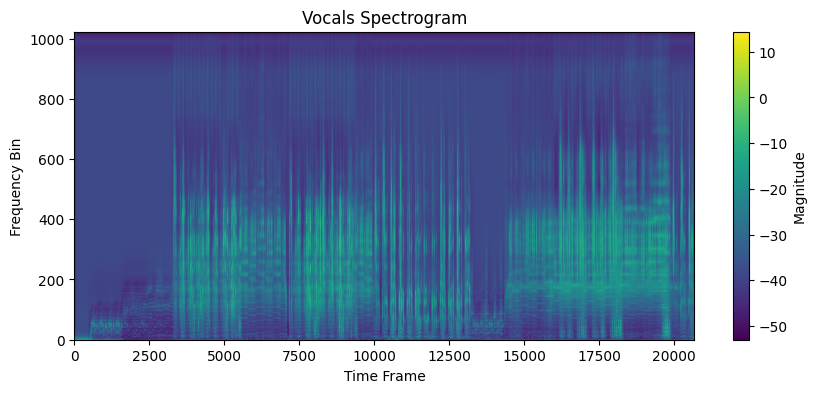

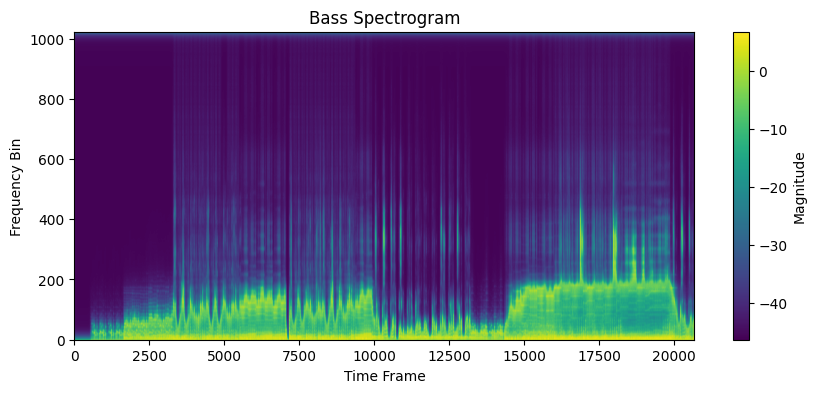

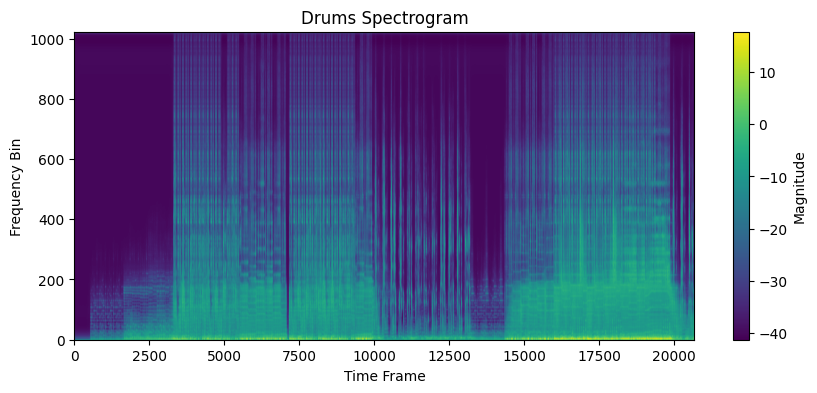

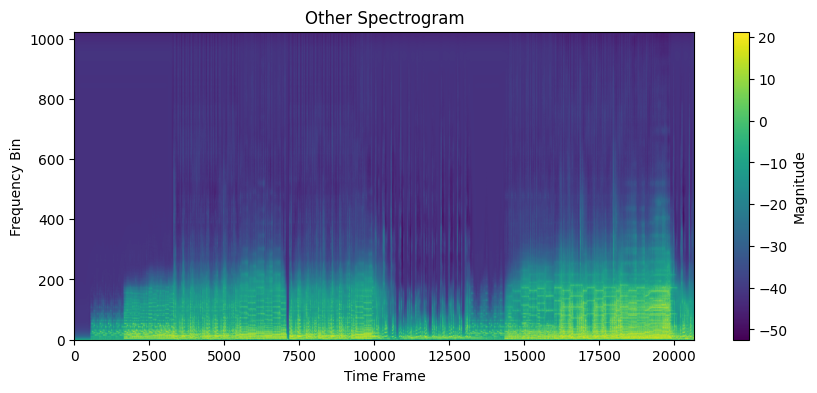

In [ ]:
display_spectrogram(predicted_spectrogram_vocals, "Vocals Spectrogram")
display_spectrogram(predicted_spectrogram_bass, "Bass Spectrogram")
display_spectrogram(predicted_spectrogram_drums, "Drums Spectrogram")
display_spectrogram(predicted_spectrogram_other, "Other Spectrogram")

In [ ]:
def center_spectrogram_magnitudes(spectrogram_data):
    """
    Normalizes the spectrogram data such that 0 is at the center of the magnitude values.

    Parameters:
    spectrogram_data (np.array): The 2D numpy array of spectrogram data.

    Returns:
    np.array: The centered spectrogram.
    """
    # Find the minimum and maximum values in the spectrogram
    min_val = np.min(spectrogram_data)
    max_val = np.max(spectrogram_data)

    # Calculate the center value to shift the magnitudes
    center_val = (max_val + min_val) / 2

    # Shift the spectrogram magnitudes so that 0 is at the center
    centered_spectrogram = spectrogram_data - center_val

    return centered_spectrogram


## Normalized Results 📋
The magnitudes are where we expect them to be!

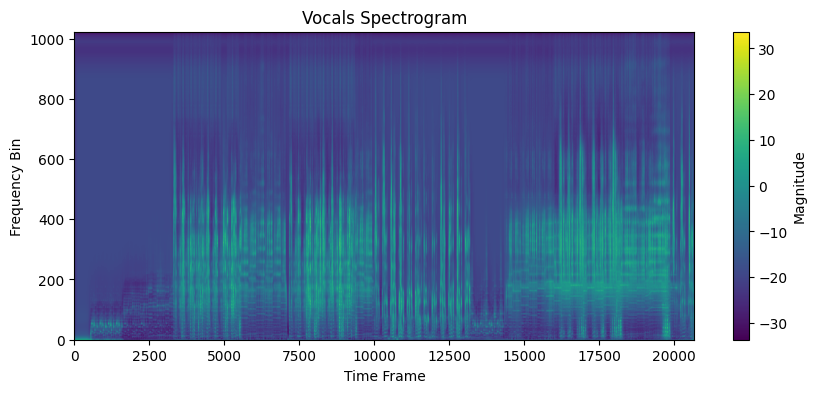

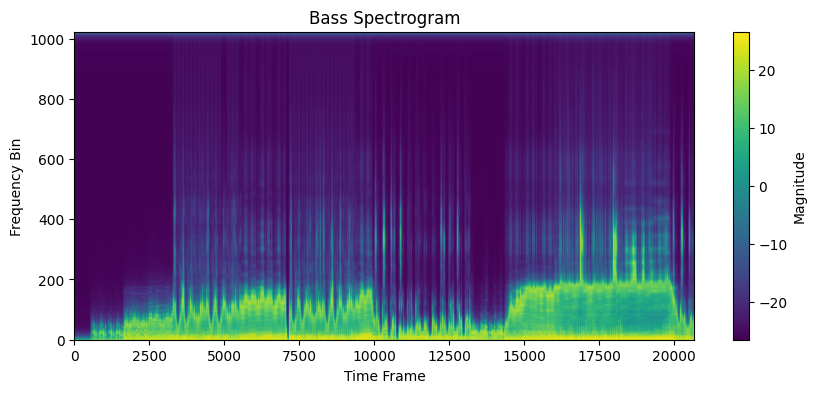

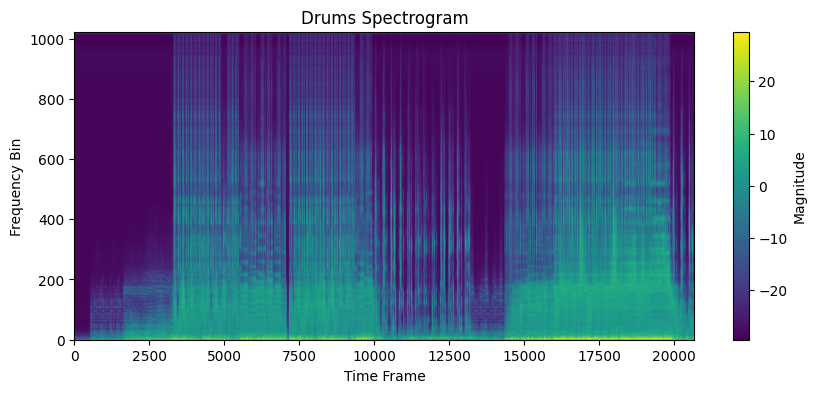

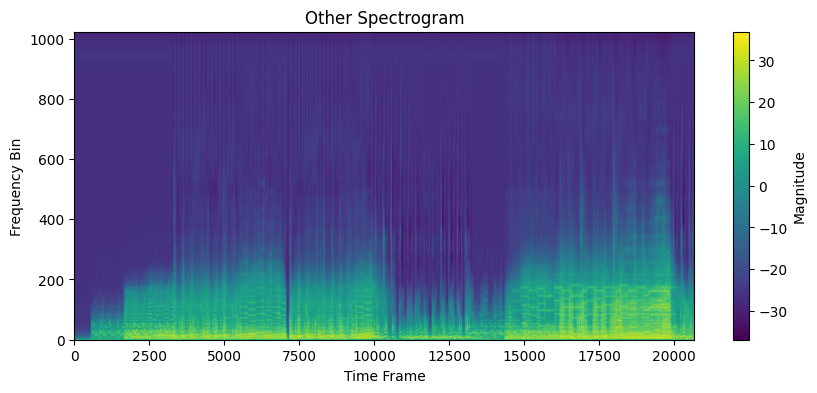

In [ ]:
display_spectrogram(center_spectrogram_magnitudes(predicted_spectrogram_vocals), "Vocals Spectrogram")
display_spectrogram(center_spectrogram_magnitudes(predicted_spectrogram_bass), "Bass Spectrogram")
display_spectrogram(center_spectrogram_magnitudes(predicted_spectrogram_drums), "Drums Spectrogram")
display_spectrogram(center_spectrogram_magnitudes(predicted_spectrogram_other), "Other Spectrogram")

In [ ]:
# Assuming spectrogram is a 2D numpy array of your spectrogram data


In [ ]:
print(spectrogram.shape)

(1025, 20680)


In [ ]:
import librosa
import soundfile as sf

def spectrogram_to_audio(spectrogram, output_file='output.wav', sr=22050):
    """
    Converts a spectrogram into an audio file.

    Parameters:
    spectrogram (np.array): The 2D numpy array of spectrogram data (complex numbers).
    output_file (str): The path to the output audio file.
    sr (int): The sampling rate of the audio file.

    Returns:
    None
    """
    # Perform the inverse Short-Time Fourier Transform (assuming spectrogram is a complex spectrogram)
    audio_signal = librosa.istft(spectrogram)

    # Write the audio signal to a file
    sf.write(f"test2.wav", audio_signal, sr, subtype='PCM_24')

# spectrogram_to_audio(centered_spectrogram[0, :, :, 0], 'test2.wav')


In [ ]:
import librosa
import soundfile as sf
import numpy as np

def spectrogram_to_audio(spectrogram, n_fft=2048, sample_rate=22050):
    """
    Converts a desired spectrogram into an audio wav and saves it.

    :param spectrogram: numpy array representing the spectrogram
    :param n_fft: fast fourier
    :param sample_rate: sample rate in Hz
    """
    # Assuming spectrogram is magnitude-only, estimate phase using Griffin-Lim
    if np.isrealobj(spectrogram):
        spectrogram = librosa.griffinlim(spectrogram)

    # Convert spectrogram to audio signal
    audio_signal = librosa.istft(spectrogram)

    # Normalize audio signal
    max_val = np.max(np.abs(audio_signal))
    if max_val > 0:
        audio_signal = audio_signal / max_val

    return audio_signal

sr = 22050

audio = spectrogram_to_audio(input_spectrogram)
sf.write(f'vocals_prediction.wav', audio, sr)

/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:257: UserWarning: n_fft=41358 is too large for input signal of length=0
  warnings.warn(


# Evaluating Results 😱

In [ ]:
test_mix_np = np.array(test_mix)
test_sep_vocals_np = np.array(test_sep_vocals)
test_sep_drums_np = np.array(test_sep_drums)
test_sep_other_np = np.array(test_sep_other)
test_sep_bass_np = np.array(test_sep_bass)

In [ ]:
import numpy as np
from sklearn.metrics import mean_squared_error
from skimage.metrics import structural_similarity as ssim

def calculate_rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

def evaluate_model(model, test_mix, test_true):
    """
    Evaluate a given model on a test set.

    :param model: The trained model to be evaluated.
    :param test_mix: Test set input (e.g., mixed spectrograms).
    :param test_true: Test set true outputs (e.g., separated vocal spectrograms).
    :return: A dictionary containing average MSE, RMSE, and SSIM scores.
    """
    mse_scores, rmse_scores, ssim_scores = [], [], []

    for X, y_true in zip(test_mix, test_true):
        # Preprocess the spectrograms
        X_processed = center_spectrogram_magnitudes(X[ :, :, 0])
        y_true_processed = center_spectrogram_magnitudes(y_true[ :, :, 0])

        # Predict
        y_pred = model.predict(X_processed[np.newaxis, ..., np.newaxis])  # Adjust dimensions as needed
        y_pred_processed = y_pred[0, ..., 0]  # Assuming the output is in the same shape

        # Compute MSE
        mse = mean_squared_error(y_true_processed, y_pred_processed)
        mse_scores.append(mse)

        # Compute RMSE
        rmse = calculate_rmse(y_true_processed, y_pred_processed)
        rmse_scores.append(rmse)

        # Compute SSIM - assuming 2D spectrograms
        s = ssim(y_true_processed, y_pred_processed)
        ssim_scores.append(s)

    # Calculate the average of the scores
    avg_scores = {
        "Average MSE": np.mean(mse_scores),
        "Average RMSE": np.mean(rmse_scores),
        "Average SSIM": np.mean(ssim_scores)
    }

    return avg_scores


In [ ]:
# Example usage
results = evaluate_model(model_checkpoint_vocals_best, test_mix, test_sep_vocals_np)
print(results)

1/1 [==============================] - 0s 55ms/step
{'Average MSE': 141.50787, 'Average RMSE': 11.674337, 'Average SSIM': 0.11260686172648864}


In [ ]:
results = evaluate_model(model_checkpoint_drums_best, test_mix, test_sep_drums_np)
print(results)

1/1 [==============================] - 0s 56ms/step
{'Average MSE': 76.63092, 'Average RMSE': 8.6598015, 'Average SSIM': 0.21614878025799458}


In [ ]:
results = evaluate_model(model_checkpoint_bass_best, test_mix, test_sep_bass_np)
print(results)

1/1 [==============================] - 0s 55ms/step
{'Average MSE': 94.39509, 'Average RMSE': 9.497337, 'Average SSIM': 0.12469745330741602}


In [ ]:
results = evaluate_model(model_checkpoint_other_best, test_mix, test_sep_other_np)
print(results)

1/1 [==============================] - 0s 55ms/step
{'Average MSE': 55.76249, 'Average RMSE': 7.3733163, 'Average SSIM': 0.10298900276300674}


## Interpretation of Results 😞 😭 😖:

### Quantitative Results 📊 :
- Average MSE (Mean Squared Error) MSE is the average of the squares of the differences between the predicted and actual values. It's a measure of the quality of an estimator; lower values are better.
    - Vocals: With an MSE of 141.50787, the model shows a moderate level of error in predicting the vocal component. This indicates significant room for improvement in the model's predictive accuracy for vocals.
    - Drums: The MSE for drums is 76.63092, suggesting comparatively lower prediction errors in this category and indicating better model performance for drums.
    - Bass: An MSE of 94.39509 for the bass component points to moderate predictive errors, highlighting areas for potential improvement.
    - Other: The 'Other' category shows an MSE of 55.76249, indicating the lowest error among the components and comparatively better model accuracy for these sounds.

- Average RMSE (Root Mean Squared Error) - RMSE is the square root of MSE, making it more interpretable as it's in the same units as the data. It provides a measure of the average magnitude of the prediction errors.
    - Vocals: The RMSE of 11.674337 for vocals confirms these average deviations and suggests the need for refinement in the model's predictions for this component.
    - Drums: An RMSE of 8.6598015 for drums implies smaller average errors, reflecting a better fit of the model for drum sounds.
    - Bass: The bass component has an RMSE of 9.497337, indicating moderate prediction errors, similar to the MSE findings.
    - Other:  With an RMSE of 7.3733163, the 'Other' category demonstrates the smallest average errors, pointing to more accurate predictions in this group.

- Average SSIM (Structural Similarity Index) - SSIM is a measure of the similarity between two images or signals, ranging from -1 (no similarity) to 1 (perfect similarity). It's particularly useful for tasks involving images or structured data, like spectrograms.
    - Vocals: An SSIM of 0.11260686172648864 for vocals suggests a low degree of structural similarity, indicating the model's limited effectiveness in capturing the detailed structure of vocal spectrograms.
    - Drums: The drums score an SSIM of 0.21614878025799458, which is higher compared to vocals, showing a better structural resemblance in drum predictions.
    - Bass: With an SSIM of 0.12469745330741602, the bass predictions show low structural similarity, similar to vocals, highlighting a need for improvement in capturing bass nuances.
    - Other: The 'Other' category has an SSIM of 0.10298900276300674, the lowest among the components, indicating challenges in accurately capturing the structural characteristics of these sounds.

### Qualititative Results 🔍:
 - General Audio Quality and Clarity: The numerical results, characterized by moderate to high MSE and RMSE values across various components (vocals, drums, bass, and other), suggest that the model struggles with accurately isolating individual audio segments from a complex mix. When listening to the separated audio files, this limitation becomes evident. The model appears to inadequately filter out the distinct elements of the mix, leading to a lack of clarity and precision in the separated tracks.

- Presence of Static and Artifacts: One of the most notable auditory characteristics of the model's output is the prevalence of static noise or interference across the separated segments. This static noise is likely a result of the model picking up and amplifying background noises or erroneously interpreting musical nuances as noise. The interference significantly detracts from the listening experience, overshadowing the musical elements that the model successfully isolates.

- Occasional Musical Elements: Despite the overall challenges, there are moments where the model manages to isolate certain musical sounds. These instances, though occasional, demonstrate that the model can identify and extract some musical components from the mix. However, these successes are sporadic and not consistent enough to deem the model reliably effective.

## General Observations 🔎 🤔
- Across all components, the consistently low SSIM values are indicative of a challenge in accurately reproducing the structural and textural qualities of the original sounds. This might lead to a separation output that, while distinct in its components, lacks the full depth, richness, and cohesion of the original audio mix. The varying performance across different components suggests that the model may benefit from more tailored approaches or adjustments specific to each type of sound, particularly focusing on improving the structural similarity to enhance the overall audio quality and listening experience.

- The qualitative experience of listening to the model's output aligns with the quantitative metrics, underscoring the model's limitations in effectively separating and reconstructing audio segments. It points towards a need for significant model refinement or a reconsideration of the approach used for audio separation. Improving the model's ability to distinguish between signal and noise, enhancing its sensitivity to the subtleties of different musical components, and reducing the introduction of artifacts are critical areas for future development.